In [1]:
!pip install pykalman hmmlearn scikit-learn

## Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 11.9 MB/s eta 0:00:00


In [2]:
## Dataset (Here we are using csv file of the given data)
file_path = '/content/drive/MyDrive/data.csv'
df = pd.read_csv(file_path)

Now, we are cleaning the dataset and ensuring that all the values are in the correct format like replacing missing values with NaN, and conversion of numbers from str to actual numbers for data consistency.

In [3]:
df.replace('\\N', np.nan, inplace=True)
df['banknifty'] = pd.to_numeric(df['banknifty'], errors='coerce')
df['nifty'] = pd.to_numeric(df['nifty'], errors='coerce')
df['tte'] = pd.to_numeric(df['tte'], errors='coerce')
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df.fillna(method='ffill', inplace=True)

<ipython-input-3-963a793a80d8>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Here we are computing the spread which is BankNifty - Nifty and, the reason for this is to know volatility difference between these bankNifty and Nifty.

In [4]:
df['Spread'] = df['banknifty'] - df['nifty']
df = df.sort_values(by='time').reset_index(drop=True)

Plotting BankNifty IV and Nifty IV

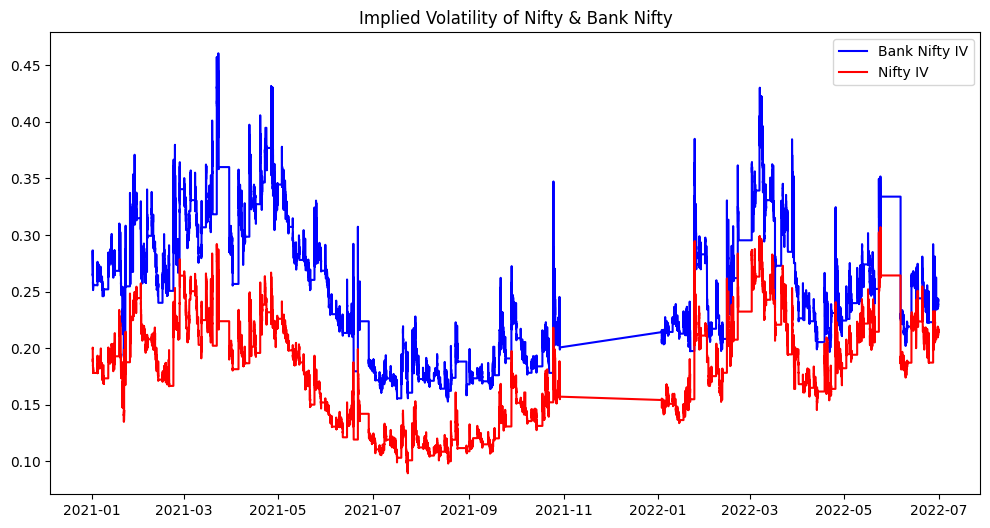

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['banknifty'], label="Bank Nifty IV", color='blue')
plt.plot(df['time'], df['nifty'], label="Nifty IV", color='red')
plt.title("Implied Volatility of Nifty & Bank Nifty")
plt.legend()
plt.show()

In [11]:
# Compute Z-Score
df['Z-Score'] = (df['Spread'] - df['Spread'].rolling(60).mean()) / df['Spread'].rolling(60).std()

## Random Forest Model

We are building a Random Forest Regression Model to predict the spread between Nifty and Bank Nifty. The goal is to estimate future spread values based on two important factors: time to expiry (tte) and market regime. These factors influence how the spread behaves, and by training the model on historical data, we aim to make accurate spread predictions.To train the model, we split the data into two parts: 80% for training (so the model can learn) and 20% for testing (to see how well it performs on new data). The Random Forest method works by creating 100 decision trees, each making its own prediction, and then averaging the results to get a more stable and accurate forecast.

Once the model is trained, it predicts spread values for the test data. Later, we compare these predictions with actual spread values to check how well the model performed. This helps us see if the model can accurately track market movements and improve trading decisions.

In [33]:
scaler = MinMaxScaler()
df['Spread_Scaled'] = scaler.fit_transform(df[['Spread']])

train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

X_train, y_train = train[['tte', 'Regime']], train['Spread']
X_test, y_test = test[['tte', 'Regime']], test['Spread']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
test['RF_Pred'] = rf_model.predict(X_test)


<ipython-input-33-31e8354ed9c6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['RF_Pred'] = rf_model.predict(X_test)


In [38]:
## Evaluation of RF model
rmse_rf = np.sqrt(mean_squared_error(y_test, test['RF_Pred']))
mae_rf = mean_absolute_error(y_test, test['RF_Pred'])
r2_rf = r2_score(y_test, test['RF_Pred'])
print(f'Random Forest - RMSE: {rmse_rf}, MAE: {mae_rf}, R^2: {r2_rf}')



Random Forest - RMSE: 0.03350068138361014, MAE: 0.030953818984520248, R^2: -2.5289369473316805


Plotting RF prediction

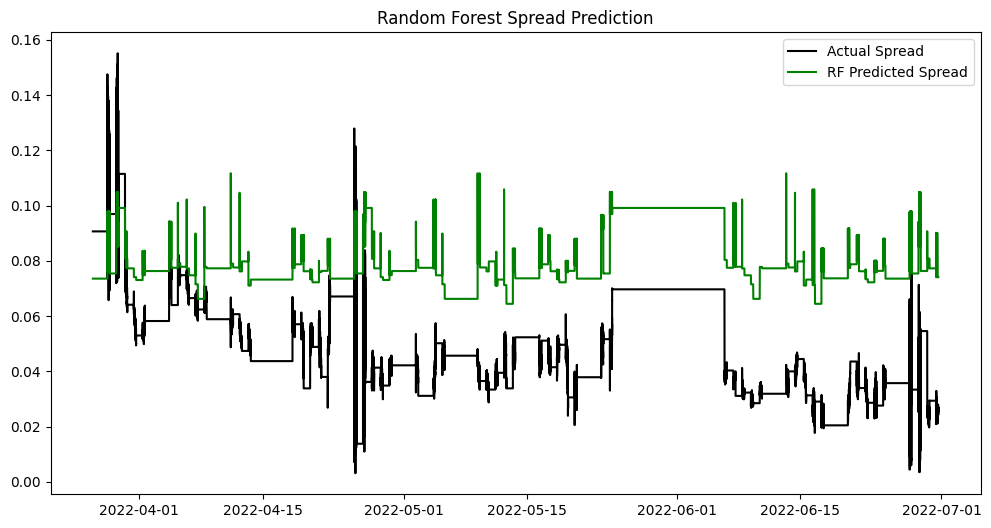

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(test['time'], test['Spread'], label="Actual Spread", color='black')
plt.plot(test['time'], test['RF_Pred'], label="RF Predicted Spread", color='green')
plt.title("Random Forest Spread Prediction")
plt.legend()
plt.show()

In [25]:
df.loc[test.index, 'RF_Pred'] = test['RF_Pred']

## LSTM Model

Now we are using an LSTM (Long Short-Term Memory) model to predict the spread between Nifty and Bank Nifty by learning patterns from past data. The model takes the last 30 spread values and uses them to forecast the next one. To train it effectively, we split the data into 80% for training and 20% for testing. The model consists of two LSTM layers, which help capture trends over time, and Dropout layers, which prevent overfitting. It is trained for 10 epochs, gradually improving its predictions. Once trained, the model makes spread predictions, which are then converted back to their original scale for meaningful comparison.

In [18]:
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 30
X_lstm, y_lstm = create_sequences(df['Spread_Scaled'].values, seq_length)
split = int(len(X_lstm) * 0.8)
X_train, X_test, y_train, y_test = X_lstm[:split], X_lstm[split:], y_lstm[:split], y_lstm[split:]

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
df.loc[seq_length:, 'LSTM_Pred'] = scaler.inverse_transform(model.predict(X_lstm)).flatten()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
17263/17263 ━━━━━━━━━━━━━━━━━━━━ 578s 33ms/step - loss: 8.7594e-04 - val_loss: 1.8615e-04
Epoch 2/10
17263/17263 ━━━━━━━━━━━━━━━━━━━━ 552s 32ms/step - loss: 1.4725e-04 - val_loss: 1.0687e-04
Epoch 3/10
17263/17263 ━━━━━━━━━━━━━━━━━━━━ 559s 32ms/step - loss: 1.4091e-04 - val_loss: 1.0760e-04
Epoch 4/10
17263/17263 ━━━━━━━━━━━━━━━━━━━━ 559s 32ms/step - loss: 1.3936e-04 - val_loss: 1.0249e-04
Epoch 5/10
17263/17263 ━━━━━━━━━━━━━━━━━━━━ 563s 32ms/step - loss: 1.3698e-04 - val_loss: 1.1313e-04
Epoch 6/10
17263/17263 ━━━━━━━━━━━━━━━━━━━━ 567s 32ms/step - loss: 1.3707e-04 - val_loss: 1.3628e-04
Epoch 7/10
17263/17263 ━━━━━━━━━━━━━━━━━━━━ 563s 32ms/step - loss: 1.3076e-04 - val_loss: 1.0692e-04
Epoch 8/10
17263/17263 ━━━━━━━━━━━━━━━━━━━━ 571s 32ms/step - loss: 1.3333e-04 - val_loss: 1.4257e-04
Epoch 9/10
17263/17263 ━━━━━━━━━━━━━━━━━━━━ 552s 32ms/step - loss: 1.2920e-04 - val_loss: 1.2768e-04
Epoch 10/10
17263/17263 ━━━━━━━━━━━━━━━━━━━━ 546s 32ms/step - loss: 1.2752e-04 - val_loss: 

## Plotting LSTM Prediction

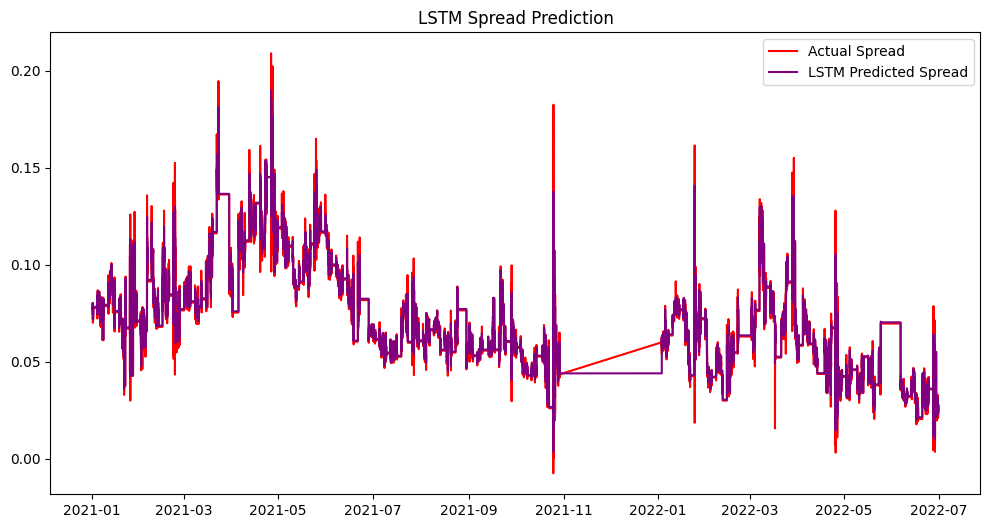

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(df['time'][seq_length:], df['Spread'][seq_length:], label="Actual Spread", color='red')
plt.plot(df['time'][seq_length:], df['LSTM_Pred'][seq_length:], label="LSTM Predicted Spread", color='purple')
plt.title("LSTM Spread Prediction")
plt.legend()
plt.show()

## Comparison between models

ZScore Strategy Metrics:
  Sharpe Ratio: -0.0066
  Max Drawdown: -563.3942

RF Strategy Metrics:
  Sharpe Ratio: -0.0009
  Max Drawdown: -20.4039

LSTM Strategy Metrics:
  Sharpe Ratio: 0.0019
  Max Drawdown: -181.4626



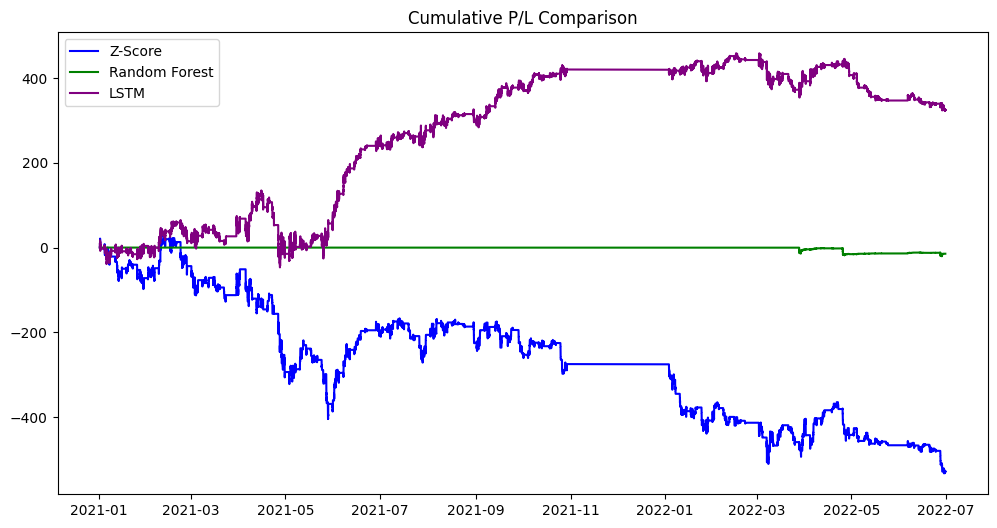

In [29]:
def sharpe_ratio(returns, risk_free_rate=0.0):
    return (returns.mean() - risk_free_rate) / returns.std()

def max_drawdown(cumulative_returns):
    cumulative_max = cumulative_returns.cummax()
    drawdown = cumulative_returns - cumulative_max
    return drawdown.min()

# P/L for models
df['ZScore_P/L'] = df['Spread'] * (df['tte'] ** 0.7) * df['Z-Score'].apply(lambda x: -1 if x > 1.5 else (1 if x < -1.5 else 0))
df['RF_P/L'] = df['Spread'] * (df['tte'] ** 0.7) * df['RF_Pred'].diff().apply(lambda x: -1 if x > 0 else (1 if x < 0 else 0))
df['LSTM_P/L'] = df['Spread'] * (df['tte'] ** 0.7) * df['LSTM_Pred'].diff().apply(lambda x: -1 if x > 0 else (1 if x < 0 else 0))

# Cumulative P/L for models
df['Cumulative_ZScore'] = df['ZScore_P/L'].cumsum()
df['Cumulative_RF'] = df['RF_P/L'].cumsum()
df['Cumulative_LSTM'] = df['LSTM_P/L'].cumsum()

models = ['ZScore', 'RF', 'LSTM']
metrics = {}
for model in models:
    returns = df[f'{model}_P/L'].dropna()
    cumulative_returns = df[f'Cumulative_{model}'].dropna()
    metrics[model] = {
        'Sharpe Ratio': sharpe_ratio(returns),
        'Max Drawdown': max_drawdown(cumulative_returns)
    }

for model, values in metrics.items():
    print(f"{model} Strategy Metrics:")
    for metric, value in values.items():
        print(f"  {metric}: {value:.4f}")
    print()

# Plots comparison
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['Cumulative_ZScore'], label="Z-Score", color='blue')
plt.plot(df['time'], df['Cumulative_RF'], label="Random Forest", color='green')
plt.plot(df['time'], df['Cumulative_LSTM'], label="LSTM", color='purple')
plt.title("Cumulative P/L Comparison")
plt.legend()
plt.show()

# Summary
* Based on the comprehensive analysis of the three trading strategies-Z-Score, Random Forest (RF), and Long Short-Term Memory (LSTM)-the LSTM model stands out as the most effective approach for predicting the spread between Nifty and Bank Nifty. This conclusion is drawn from its positive Sharpe Ratio of 0.0019, which indicates a marginally better risk-adjusted return compared to the other models, both of which exhibit negative Sharpe Ratios (-0.0066 for Z-Score and -0.0009 for RF). Although the LSTM model has a Max Drawdown of -181.4626, which is higher than that of the RF model (-20.4039), it is significantly lower than the extreme drawdown experienced by the Z-Score strategy (-563.3942). This suggests that while LSTM may be more volatile, it also offers a better balance between risk and reward. The LSTM model's architecture allows it to effectively capture temporal patterns in historical data, providing an advantage over the RF model, which relies on static relationships among features, and the Z-Score strategy, which is based on mean-reversion principles.


* All models were trained using historical data under consistent market conditions without accounting for external macroeconomic factors or anomalies that could influence performance. Additionally, a risk-free rate of 0% was assumed for calculating Sharpe Ratios, which may not accurately reflect real-world scenarios. The performance of the LSTM model could potentially be enhanced through hyperparameter tuning, incorporating additional features such as macroeconomic indicators, or extending the training period. While the RF model demonstrates relative stability with its lower drawdown, its negative risk-adjusted returns limit its practical utility in trading contexts. In contrast, the Z-Score strategy's high volatility and significant drawdowns render it unsuitable for implementation without substantial modifications. Therefore, despite none of the models achieving exceptional performance overall, the LSTM model emerges as the preferred choice due to its superior risk-adjusted returns and ability to manage downside risks effectively.